#### Выполнили Густомясова Софья и Сакова Арина

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

####  Вспомогательные функции для рекурсивного обхода дерева

In [3]:
def f(l1 , l2):
    return np.sign(l1)*np.sign(l2)*np.minimum(np.abs(l1),np.abs(l2))

In [4]:
def satx(x, th):
    return np.minimum(np.maximum(x,-th), th)

In [5]:
def g(l1, l2, bit):
    return satx(l2+(1-2*bit)*l1, maxqr)

####  Successive cancellation decoder

In [6]:
def polar_decode(y, frozen_bits_indicator):
    
    n = y.shape[0]
    if n==2:
        L_u_1 = f(y[0],y[1])
        u = np.zeros(2)
        if frozen_bits_indicator[0]==1:
            u[0] = 0
        elif L_u_1>= 0:
            u[0] = 0
        else:
            u[0] = 1

        L_u_2 = g(y[0], y[1], u[0])
        if frozen_bits_indicator[1] == 1:
            u[1] = 0
        elif L_u_2 >= 0:
            u[1] = 0
        else:
            u[1] = 1
            
        v = np.zeros(2)
        v[0] = np.mod(u[0]+u[1], 2)
        v[1] = u[1]
        
        return u, v
    
    else:
        y_left = np.zeros(n//2)
        
        for i in range(0, n//2):
            y_left[i] = f(y[2*i],y[2*i+1])
            
        frozen_bits_indicator_1 = frozen_bits_indicator[:n//2]
        
        u1, v1 =polar_decode(y_left, frozen_bits_indicator_1)
        
        y_right = np.zeros(n//2)
        
        for i in range(0, n//2):
            y_right[i] = g(y[2*i], y[2*i+1], v1[i])
            
        frozen_bits_indicator_2 = frozen_bits_indicator[n//2:]
        
        u2, v2 = polar_decode(y_right, frozen_bits_indicator_2)
        
        u = np.concatenate([u1, u2])
        
        v = np.zeros(n)
        
        for i in range(0, n//2):
            v[2*i] = np.mod(v1[i]+v2[i], 2)
            v[2*i+1] = v2[i]
            
        return u, v

####  Successive cancellation list decoder

In [7]:
def polar_decode_list(y,ff,L,listprob=np.array([0]),u=np.array([[]])):
    N = y.shape[1] #??
    if N==1:
        Lp=np.concatenate([(y<0)*y,(y>=0)*(-y)], axis =-1)  #simple approximation
        L0 = y.shape[0]#??
        if ff[0]==1/2:
            # Make list of all possible decisions (double the list size)
            listprob = np.concatenate([listprob+Lp[:,1], listprob+Lp[:,0]])
            j = np.argsort(listprob)[::-1]
            listprob = listprob[j]
            if j.shape[0] > L:
                listprob = listprob[:L]
                j = j[:L]
            # the first half of the list was due to x=1
            x = np.array((j < L0), dtype=int).reshape(-1,1)
            idx = np.mod(j,L0)
            u = u[idx,:]
            u = np.concatenate([u,x], axis=1)
            return u, x, idx, listprob
            # determine which path each decision belongs to
        else:
            x = np.zeros(L0).reshape(-1,1)
            u = np.concatenate([u,x], axis=1)
            idx = np.arange(L0)
            listprob = listprob + Lp[:,0] # Or better avoid modifing it?
            return u, x, idx, listprob
    else:
        u1est = f(y[:, ::2],y[:, 1::2])
        uhat1, u1hardprev, idx1, prob1 = polar_decode_list(u1est, ff[:N//2], L, listprob, u)
        u2est = g(y[idx1, ::2], y[idx1, 1::2], u1hardprev)
        uhat2, u2hardprev, idx2, prob2 = polar_decode_list(u2est,ff[N//2:],L,prob1,uhat1)
        u = uhat2
        x = np.zeros([len(idx2), u2hardprev.shape[1]*2])
        x[:, ::2]= np.mod(u1hardprev[idx2,:]+u2hardprev, 2)
        x[:, 1::2] = u2hardprev
        listprob = prob2;
        idx = idx1[idx2] #?? 
        return u, x, idx, listprob

####  Модифицированный Successive cancellation list decoder

In [8]:
def polar_decode_list_fast(y,ff,L,listprob=np.array([0]),u=np.array([[]])):
    N = y.shape[1] #??
    if N==1:
        Lp=np.concatenate([(y<0)*y,(y>=0)*(-y)], axis =-1)  #simple approximation
        L0 = y.shape[0]#??
        if ff[0]==1/2:
            # Make list of all possible decisions (double the list size)
            listprob = np.concatenate([listprob+Lp[:,1], listprob+Lp[:,0]])
            j = np.argsort(listprob)[::-1]
            listprob = listprob[j]
            if j.shape[0] > L:
                listprob = listprob[:L]
                j = j[:L]
            # the first half of the list was due to x=1
            x = np.array((j < L0), dtype=int).reshape(-1,1)
            idx = np.mod(j,L0)
            u = u[idx,:]
            u = np.concatenate([u,x], axis=1)
            return u, x, idx, listprob
            # determine which path each decision belongs to
        else:
            x = np.zeros(L0).reshape(-1,1)
            u = np.concatenate([u,x], axis=1)
            idx = np.arange(L0)
            listprob = listprob + Lp[:,0] # Or better avoid modifing it?
            return u, x, idx, listprob
    elif (ff==1/2).all():
        u,x,idx,listprob=decRate1(y,L,listprob,u) #dec Rate1
        return u,x,idx,listprob
    elif (ff==0).all():
        u,x,idx,listprob=decRate0(y,listprob,u) #dec Rate0
        return u,x,idx,listprob
    elif ff[-1]==1/2 and (ff[:-1]==0).all():
        u,x,idx,listprob=decRepCode(y,L,listprob,u)#dec Repetition code
        return u,x,idx,listprob
    elif ff[0]==0 and (ff[1:]==1/2).all():
        u,x,idx,listprob=decSPCCode(y,L,listprob,u)#dec SPC code 
        return u,x,idx,listprob
    else:
        u1est = f(y[:, ::2],y[:, 1::2])
        uhat1, u1hardprev, idx1, prob1 = polar_decode_list(u1est, ff[:N//2], L, listprob, u)
        u2est = g(y[idx1, ::2], y[idx1, 1::2], u1hardprev)
        uhat2, u2hardprev, idx2, prob2 = polar_decode_list(u2est,ff[N//2:],L,prob1,uhat1)
        u = uhat2
        x = np.zeros([len(idx2), u2hardprev.shape[1]*2])
        x[:, ::2]= np.mod(u1hardprev[idx2,:]+u2hardprev, 2)
        x[:, 1::2] = u2hardprev
        listprob = prob2;
        idx = idx1[idx2] #?? 
        return u, x, idx, listprob

####  Вспомогательные функции для модифицированного Successive cancellation list decoder

In [9]:
def decRate1(y,L,listprob,u):
    u_hat=np.kron(np.array((y<0), dtype=int),np.ones((4,1)))
    #logp=-log1p(exp(-abs(y)));
    #logp=np.zeros(y.shape[0])
    listprob=np.kron(listprob.reshape(-1,1),np.ones((4,1)))
    #print(listprob)
    for i in range(y.shape[0]):
        min_id=np.argsort(np.abs(y[i]))
        min_val=np.abs(y[i][min_id])
        s=4*i
        u_hat[[1+s,3+s],min_id[0]]=1-u_hat[[1+s,3+s],min_id[0]]
        u_hat[[2+s,3+s],min_id[1]]=1-u_hat[[2+s,3+s],min_id[1]]
        listprob[[1+s,3+s]]=listprob[[1+s,3+s]]-min_val[0]
        listprob[[2+s,3+s]]=listprob[[2+s,3+s]]-min_val[1]
    listprob = listprob.reshape(1,-1)[0]
    #print(listprob)
    j = np.argsort(listprob)[::-1]
    listprob = listprob[j]
    index_list=np.min([L,listprob.shape[0]])
    listprob=listprob[:index_list]
    j=j[:index_list]
    x=u_hat[j]
    idx=np.array(j//4, dtype=int)
    u=np.concatenate([u[idx], polar_transform_mat(x)], axis=-1)
    return u, x, idx, listprob

In [10]:
def decRate0(y,listprob,u):
    N=y.shape[1]
    #LogP = llr2logp(y);
    LogP=np.concatenate([(y<0)*y,(y>=0)*(-y)], axis =-1)
    listprob=listprob+np.sum(LogP[:,:N],1)
    idx=np.arange(len(listprob))
    x=np.zeros_like(y)
    if u.shape[1]==0:
        u = np.zeros_like(y)
    else:
        u=np.concatenate([u[idx], x], axis =-1)
    return u, x, idx, listprob

In [11]:
def decRepCode(y,L,listprob,u):
    N=y.shape[1]
    u_hat=np.concatenate([np.zeros_like(y), np.ones_like(y)])
    #LogP = llr2logp(y);
    LogP=np.concatenate([(y<0)*y,(y>=0)*(-y)], axis =-1)
    listprob=np.concatenate([listprob+np.sum(LogP[:,:N],1), listprob+np.sum(LogP[:,N:],1)])
    j = np.argsort(listprob)[::-1]
    listprob = listprob[j]
    index_list=np.min([L,listprob.shape[0]])
    listprob=listprob[:index_list]
    j=j[:index_list]
    x=u_hat[j]
    idx = np.mod(j, y.shape[0])
    if u.shape==(1,0):
        u=polar_transform_mat(x)
    else:
        u=np.concatenate([u[idx], polar_transform_mat(x)], axis=-1)
    return u, x, idx, listprob  

In [12]:
def decSPCCode(y,L,listprob,u):
    u_hat=np.kron(np.array((y<0), dtype=int),np.ones((8,1)))
    #logp=-log1p(exp(-abs(y)));
    listprob=np.kron(listprob.reshape(-1,1),np.ones((8,1)))
    for i in range(y.shape[0]):
        q=np.mod(np.sum(y[i]<0),2) 
        min_id=np.argsort(np.abs(y[i]))
        min_val=np.abs(y[i][min_id])
        s=8*i
        if q == 1:
            u_hat[s:s+7,min_id[1]]=1-u_hat[s:s+7,min_id[1]]
            listprob[s:s+7]=listprob[s:s+7]-min_val[1]
            min_val[1]=-min_val[1]
        #V=nchoosek(1:4,2);
        V=np.array([[0,0,0,1,1,2],[1,2,3,2,3,3]]).T
        for j in range(V.shape[0]):
            u_hat[s+j,min_id[V[j]]]=1-u_hat[s+j,min_id[V[j]]]
            listprob[s+j]=listprob[s+j]-np.sum(min_val[V[j]])
        u_hat[s+7,min_id[:4]]=1-u_hat[s+7,min_id[:4]]  
        listprob[s+7]=listprob[s+7]-np.sum(min_val[:4])
    listprob = listprob.reshape(1,-1)[0]
    j = np.argsort(listprob)[::-1]
    listprob = listprob[j]
    index_list=np.min([L,listprob.shape[0]])
    listprob=listprob[:index_list]
    j=j[:index_list]
    x=u_hat[j]
    idx=np.array(j//8, dtype=int)
    u=np.concatenate([u[idx], polar_transform_mat(x)], axis=-1)
    return u, x, idx, listprob

#### Функции для прямого кодирования

In [13]:
def polar_encode(u, frozen_bits_indicator):
    N = u.shape[0]
    n = np.log2(N)
    u[frozen_bits_indicator == 1] = 0
    x = polar_encode_recursive(u)
    return x

In [14]:
def polar_encode_recursive(u):
    N = u.shape[0]
    n = np.log2(N)
    G = np.array([[1,0],[1,1]])
    if N == 2:
        y = np.mod(u @ G, 2)
        return y  

    u_1 = np.zeros(N)
    u_1[::2] = np.mod(u[::2]+u[1::2],2)
    u_1[1::2] = u[1::2]
    u_2 = np.concatenate([u_1[::2], u_1[1::2]])

    y_1 = polar_encode_recursive(u_2[:N//2])
    y_2 = polar_encode_recursive(u_2[N//2:])

    y = np.concatenate([y_1, y_2])
    return y

In [15]:
def polar_transform_mat(u):
    if (u.shape[1]==1):
        return u
    u1u2 = np.mod(u[:,::2]+u[:,1::2],2)
    u2 = u[:,1::2]
    x = np.concatenate([polar_transform_mat(u1u2), polar_transform_mat(u2)], axis=-1)
    return x

#### 5G frozen channels

In [16]:
filepath = os.path.join('rank.csv')
table_data = pd.read_csv(filepath)
W = table_data['W'].apply(str.split)
array = W.to_numpy()
array = [ list(map(int, elem))  for elem in array]
array = np.array([ elem[1] for elem in array])

####  Тест функции polar_decode

In [17]:
n=8
M=2
N = 2**n
Rate=1/2
fe=40
K=int(N*Rate)
EbNoArray=np.arange(1,2,0.1)
FER_SC = np.zeros_like(EbNoArray)
channels = array[array<N]
frozen_indices = channels[:(N-K)]
frozen_bits_indicator=np.zeros(N)
frozen_bits_indicator[frozen_indices]=1
ff=np.empty_like(frozen_bits_indicator)
ff[frozen_bits_indicator==0]=1/2
ff[frozen_bits_indicator==1]=0
G=np.empty([K, N])
I = np.eye(K)
for i in range(K):
    c = np.zeros(N)
    c[frozen_bits_indicator==0] = I[i]
    x = polar_encode(c,frozen_bits_indicator)
    G[i] = x

In [18]:
rmax = 4
maxqr = 31
for i  in range(len(EbNoArray)):
    EbNo=EbNoArray[i]
    noiseVar = 10.**(EbNo/10)
    sigma = np.sqrt(1/(2*Rate*EbNo))
    f_sc=0
    Itr=0
    while f_sc<fe:
        Itr=Itr+1
        u=np.random.randint(0, 2 , K)
        c1 = np.mod(u @ G,2)
        u1 = polar_transform_mat(c1.reshape(1,-1))[0]
        s = 1-2*c1#BPSK bit to symbol conversion
        r = s+sigma*np.random.randn(N)#AWGN channel
        #quantization
        r = satx(r, rmax)
        rq = np.round(r/rmax*maxqr)
        decoded_bits1,_ = polar_decode(rq, frozen_bits_indicator)
        if (decoded_bits1!=u1).any():
            f_sc=f_sc+1
    FER_SC[i]=f_sc/Itr
    print(FER_SC[i])

0.8888888888888888
0.8163265306122449
0.5970149253731343
0.5797101449275363
0.3448275862068966
0.26143790849673204
0.12307692307692308
0.09876543209876543
0.048721071863580996
0.035056967572304996


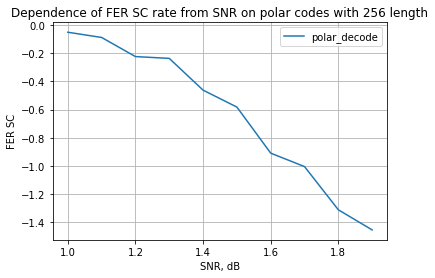

In [19]:
fig, ax = plt.subplots()
ax.plot(EbNoArray, np.log10(FER_SC), label='polar_decode')
#ax.plot(EbNoArray[:8], np.exp(-EbNoArray[:8]), label='exp')
plt.xlabel('SNR, dB')
plt.ylabel('FER SC')
plt.legend(loc='best')
plt.title("Dependence of FER SC rate from SNR on polar codes with 256 length")
plt.grid()
plt.show()

#### Функции для cyclic redundancy check

In [20]:
def xor(a,b):
    n = b.shape[0]
    return np.mod(a[1:n]+b[1:n],2)

In [21]:
def mod2div(divident, divisor):
    # Number of bits to be XORed at a time.
    pick = len(divisor)
   
    # Slicing the divident to appropriate
    # length for particular step
    tmp = divident[0:pick]
   
    while pick < len(divident):
        if tmp[0] == 1:
            # replace the divident by the result
            # of XOR and pull 1 bit down
            tmp = np.append(xor(divisor, tmp),divident[pick])
   
        else:   # If leftmost bit is '0'
  
            # If the leftmost bit of the dividend (or the
            # part used in each step) is 0, the step cannot
            # use the regular divisor; we need to use an
            # all-0s divisor.
            tmp = np.append(xor(np.zeros(pick), tmp),divident[pick])
   
        # increment pick to move further
        pick += 1
   
    # For the last n bits, we have to carry it out
    # normally as increased value of pick will cause
    # Index Out of Bounds.
    if tmp[0] == 1:
        tmp = xor(divisor, tmp)
    else:
        tmp = xor(np.zeros(pick), tmp)
   
    checkword = tmp
    return checkword

In [22]:
# Function used at the sender side to encode
# data by appending remainder of modular division
# at the end of data.
def encodeData(data, key):
   
    l_key = len(key)
   
    # Appends n-1 zeroes at end of data
    appended_data = np.concatenate([data,np.zeros(l_key-1)])
    remainder = mod2div(appended_data, key)
    # Append remainder in the original data
    codeword = np.concatenate([data, remainder]).astype(int)
    return codeword 

In [23]:
def decodeData(data, key):
   
    l_key = len(key)
   
    # Appends n-1 zeroes at end of data
    appended_data = np.concatenate([data,np.zeros(l_key-1)])
    remainder = mod2div(appended_data, key)
   
    return remainder

In [24]:
def check(data, key):
    remainder = decodeData(data, key)
    if np.sum(remainder)==0:
        #print("THANK you Data ->", *data," Received No error FOUND")
        return True
    else:
        #print("Error in data")
        return False
  

#### Тест функции polar_decode_list

In [25]:
n=8
M=2
N = 2**n
Rate=1/2
List_size=16
fe=40
K=int(N*Rate)
EbNoArray=np.arange(1,2,0.1)
FER_SC_l = np.zeros_like(EbNoArray)
crc_poly='z^9 + z^8 + z^6 + z^5 + z^3 + z^2 + 1'
#crc_poly = '1101101101'
#key = '101101'
key = np.array([1,0,1,1,0,1])
key = np.array([1,1,0,1,1,0,1,1,0,1])
poly_deg=9


#5G frozen channels
channels = array[array<N]
frozen_indices = channels[:N-K-poly_deg]
frozen_bits_indicator=np.zeros(N)
frozen_bits_indicator[frozen_indices]=1
ff=np.empty_like(frozen_bits_indicator)
ff[frozen_bits_indicator==0]=1/2
ff[frozen_bits_indicator==1]=0
frozen_bits_indicator=frozen_bits_indicator.astype(int)
G=np.empty([K+poly_deg, N])
I = np.eye(K+poly_deg)

for i in range(K+poly_deg):
    c = np.zeros(N)
    c[frozen_bits_indicator==0] = I[i]
    x = polar_encode(c,frozen_bits_indicator)
    G[i] = x

In [26]:
import time
rmax = 4
maxqr = 31
t = np.array([])
for i  in range(len(EbNoArray)):
    EbNo=EbNoArray[i]
    noiseVar = 10.**(EbNo/10)
    sigma = np.sqrt(1/(2*Rate*EbNo))
    f_sc=0
    Itr=0
    while f_sc<fe:
        Itr=Itr+1
        u=np.random.randint(0, 2 , K)
        u_inner = encodeData(u, key)
        c1 = np.mod(u_inner @ G,2)
        u1 = polar_transform_mat(c1.reshape(1,-1))[0]
        s = 1-2*c1 #BPSK bit to symbol conversion
        r = s+sigma*np.random.randn(N) #AWGN channel
        #quantization
        r = satx(r, rmax)
        rq = np.round(r/rmax*maxqr)
        t0 = time.time()
        decoded_bits1,_,_,_ =  polar_decode_list(rq.reshape(1,-1), ff, 16)
        t1 = time.time()
        dt = t1 - t0
        t = np.append(t, dt)
        cands=[]
        for l in range(List_size):
            uu=decoded_bits1[l]
            if check(uu[frozen_bits_indicator==0], key):
                cands.append(uu)
        if len(cands)==0:
            decoded_bits1=decoded_bits1[0]
        else:
            decoded_bits1=cands[0]
        if (decoded_bits1!=u1).any():
            f_sc=f_sc+1
    FER_SC_l[i]=f_sc/Itr
    print(FER_SC_l[i])

0.7547169811320755
0.6153846153846154
0.42105263157894735
0.17857142857142858
0.08639308855291576
0.042826552462526764
0.015117157974300832
0.005436259853220984
0.001402819667531739
0.0006385594099711052


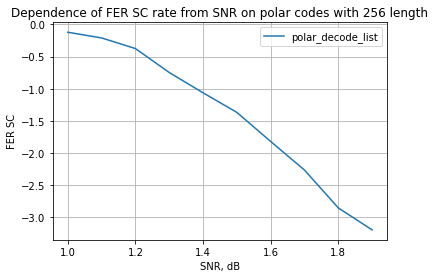

In [27]:
fig, ax = plt.subplots()
ax.plot(EbNoArray, np.log10(FER_SC_l), label='polar_decode_list')
plt.xlabel('SNR, dB')
plt.ylabel('FER SC')
plt.legend(loc='best')
plt.title("Dependence of FER SC rate from SNR on polar codes with 256 length")
plt.grid()
plt.show()

#### Тест функции polar_decode_list_fast

In [28]:
FER_SC_lf = np.zeros_like(EbNoArray)
rmax = 4
maxqr = 31
t = np.array([])
for i  in range(len(EbNoArray)):
    EbNo=EbNoArray[i]
    noiseVar = 10.**(EbNo/10)
    sigma = np.sqrt(1/(2*Rate*EbNo))
    f_sc=0
    Itr=0
    while f_sc<fe:
        Itr=Itr+1
        u=np.random.randint(0, 2 , K)
        u_inner = encodeData(u, key)
        c1 = np.mod(u_inner @ G,2)
        u1 = polar_transform_mat(c1.reshape(1,-1))[0]
        s = 1-2*c1 #BPSK bit to symbol conversion
        r = s+sigma*np.random.randn(N) #AWGN channel
        #quantization
        r = satx(r, rmax)
        rq = np.round(r/rmax*maxqr)
        t0 = time.time()
        decoded_bits1,_,_,_ =  polar_decode_list_fast(rq.reshape(1,-1), ff, 16)
        t1 = time.time()
        dt = t1 - t0
        t = np.append(t, dt)
        cands=[]
        for l in range(List_size):
            uu=decoded_bits1[l]
            if check(uu[frozen_bits_indicator==0], key):
                cands.append(uu)
        if len(cands)==0:
            decoded_bits1=decoded_bits1[0]
        else:
            decoded_bits1=cands[0]
        if (decoded_bits1!=u1).any():
            f_sc=f_sc+1
    FER_SC_lf[i]=f_sc/Itr
    print(FER_SC_lf[i])

0.7407407407407407
0.5714285714285714
0.40404040404040403
0.17699115044247787
0.10335917312661498
0.03636363636363636
0.012445550715619166
0.007578628268283441
0.0016163575382874692
0.0005774505557961599


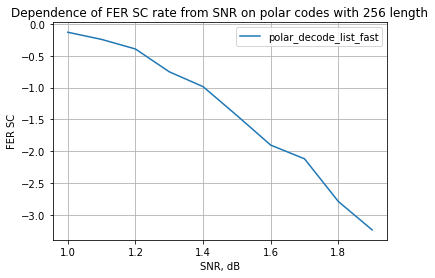

In [29]:
fig, ax = plt.subplots()
ax.plot(EbNoArray, np.log10(FER_SC_lf), label='polar_decode_list_fast')
plt.xlabel('SNR, dB')
plt.ylabel('FER SC')
plt.legend(loc='best')
plt.title("Dependence of FER SC rate from SNR on polar codes with 256 length")
plt.grid()
plt.show()

#### Общий график

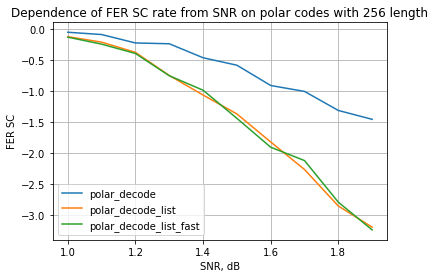

In [30]:
fig, ax = plt.subplots()
ax.plot(EbNoArray, np.log10(FER_SC), label='polar_decode')
ax.plot(EbNoArray, np.log10(FER_SC_l), label='polar_decode_list')
ax.plot(EbNoArray, np.log10(FER_SC_lf), label='polar_decode_list_fast')
plt.xlabel('SNR, dB')
plt.ylabel('FER SC')
plt.legend(loc='best')
plt.title("Dependence of FER SC rate from SNR on polar codes with 256 length")
plt.grid()
plt.show()